To setup the environment run the following commands on kaggle

In [1]:
!cp /kaggle/input/a3-1-1/A3/environment.yml /kaggle/working/
!cp /kaggle/input/a3-1-1/A3/install.sh /kaggle/working/

!bash install.sh

Installing dependencies from environment.yml using pip...
Environment setup completed successfully!


Run your .py file on CLI using the following command

In [2]:
# !python bird.py path_to_dataset train bird.pth

In [3]:
# !python bird.py path_to_dataset test bird.pth

# Models to be tested

### Preprocessing

1. Load Images as tensors ✅ 
2. Transform the images  
    - Padding ❌
    - Cropping ❌
    - Resize-ing ✅ 
3. Scale the images ✅ 
4. Normalize the images ✅ 

### Model Training

- Normal Architecture with EffNet scaling laws ✅
  > Compound Scaling Method ✅
- Add BatchNorm
- Scale the network
- Add Skip Connections
- Scale the network
- Try ResNet Like Architecture
- Try GoogleNet like Architecture
- Try Data Augmentation
  1. Random Cropping
  2. Flipping and turning
  3. Brightness/contrast adjustments
  4. Aspect Ratio Jitter
  5. Colour Jitter
  6. `Albumentations`
  7. Try Adaptive Augmentation Methods
- Try Removing Classimbalance by
  1. Data Augmentation + OverSampling
  2. Weighted Classification
  3. Focal Loss
- Learning Rate Schedulers
  1. `StepLR`
  2. `CyclicLR`
  3. `OneCylceLR`
  4. Try Learning Rate WarmUp
- Try Label Smoothing
- Try DropBlock and DropOut see which is better
- Check for Gradient Clipping 

### Model Callibration

- Try Model Calibration
  1. Temperature Scaling for Calibration
  2. Calbration with Brier Score
 
### Visualization and Debugging

- Grad-CAM
- TensorBoard
- Weights and Biases
- Update Ratios

In [4]:
# !pip list | grep pandas & pip list | grep numpy

# Train and Test Loaders

In [5]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import torch
from sklearn.metrics import f1_score

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the subfolders (0, 1, ..., 9).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate over each subdirectory (0, 1, ..., 9)
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Calculating the Mean and Std for the dataset

In [7]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader

# # Define a simple transformation to just convert images to tensors
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])

# # Load your dataset (replace with your dataset path)
# dataset = ImageDataset(root_dir="/kaggle/input/identify-the-birds/Birds/train", transform=transform)
# loader = DataLoader(dataset, batch_size=64, shuffle=False)

# # Function to calculate mean and std
# def calculate_mean_std(loader):
#     mean = 0.0
#     std = 0.0
#     total_images = 0

#     for images, _ in loader:
#         batch_samples = images.size(0)  # Batch size (number of images in the batch)
#         images = images.view(batch_samples, images.size(1), -1)  # Flatten the height and width
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images += batch_samples

#     mean /= total_images
#     std /= total_images
#     return mean, std

# mean, std = calculate_mean_std(loader)

# print(f"Mean: {mean}")
# print(f"Std: {std}")

Size - (224, 224)
> Mean: tensor([0.4838, 0.4930, 0.4104]) \
Std: tensor([0.1881, 0.1875, 0.1886])

# Loading Data

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4838, 0.493, 0.4104], std=[0.1881, 0.1875, 0.1886])
])

In [9]:
root_dir = "/kaggle/input/identify-the-birds/Birds"
train_dir = os.path.join(root_dir, "train")

dataset = ImageDataset(root_dir=train_dir, transform=transform)

labels = dataset.labels
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

## Splitting Data

In [10]:
for train_idx, test_idx in split.split(dataset.image_paths, labels):
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)

In [11]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# EDA

torch.Size([64, 3, 224, 224])


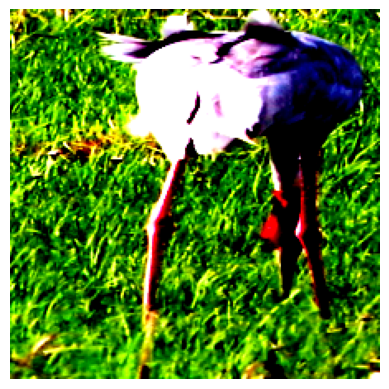

torch.Size([64])
0
torch.Size([64, 3, 224, 224])


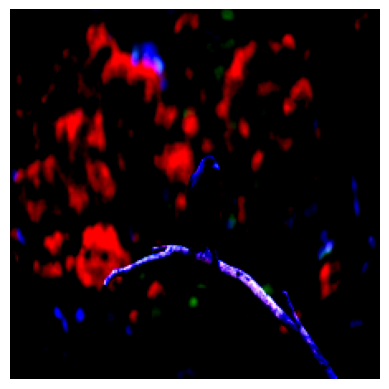

torch.Size([64])
1
torch.Size([64, 3, 224, 224])


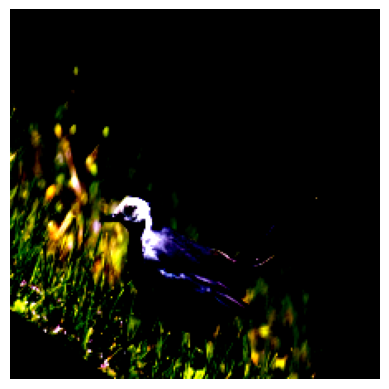

torch.Size([64])
2
torch.Size([64, 3, 224, 224])


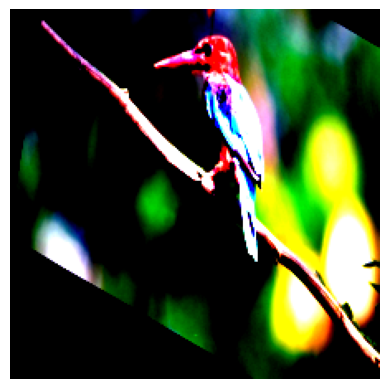

torch.Size([64])
3
torch.Size([64, 3, 224, 224])


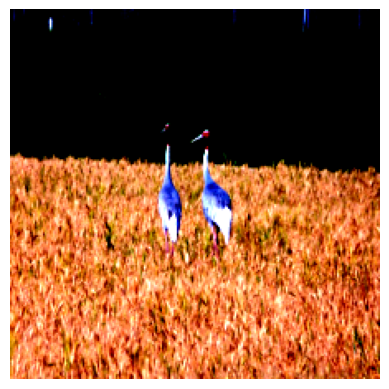

torch.Size([64])
4
torch.Size([64, 3, 224, 224])


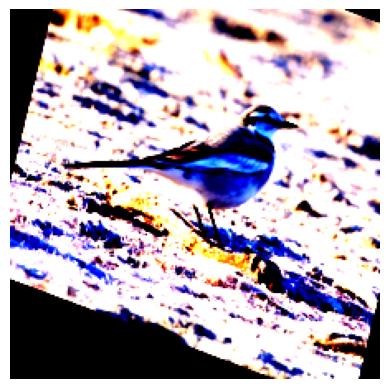

torch.Size([64])
5
torch.Size([64, 3, 224, 224])


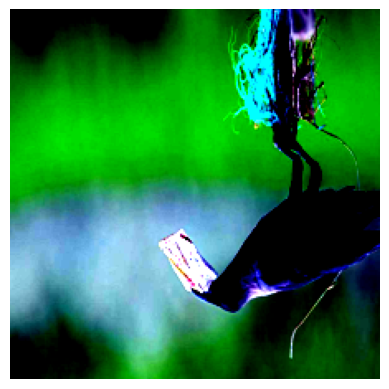

torch.Size([64])
6


In [12]:
for idx, (images, labels) in enumerate(train_loader):
    print(images.shape)

    # printing the image to see
    image_numpy = images[0].permute(1, 2, 0).numpy()
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()
    
    print(labels.shape)
    print(idx)
    if (idx > 5):
        break

### Getting a Base Line Model to run, to check what input size gives the best results

In [13]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import argparse
import os

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 112*112
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 56*56
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 28*28
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 14*14
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 7*7
            
            nn.Flatten(),
            
            nn.Linear(in_features=512 * 7 * 7, out_features=1024),
            nn.ReLU(),
            
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x):
        return self.model(x)

In [15]:
# ----------------- model training ----------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Available device: {device}")

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
print(f"No. of model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Available device: cuda
No. of model parameters: 27791626


In [16]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  model.0.weight |    864     |
|   model.0.bias  |     32     |
|  model.1.weight |     32     |
|   model.1.bias  |     32     |
|  model.4.weight |   18432    |
|   model.4.bias  |     64     |
|  model.5.weight |     64     |
|   model.5.bias  |     64     |
|  model.8.weight |   73728    |
|   model.8.bias  |    128     |
|  model.9.weight |    128     |
|   model.9.bias  |    128     |
| model.12.weight |   294912   |
|  model.12.bias  |    256     |
| model.13.weight |    256     |
|  model.13.bias  |    256     |
| model.16.weight |  1179648   |
|  model.16.bias  |    512     |
| model.17.weight |    512     |
|  model.17.bias  |    512     |
| model.21.weight |  25690112  |
|  model.21.bias  |    1024    |
| model.23.weight |   524288   |
|  model.23.bias  |    512     |
| model.25.weight |    5120    |
|  model.25.bias  |     10     |
+-----------------+------------+
Total Trai

27791626

In [17]:
from torch.optim.lr_scheduler import StepLR

# Define optimizer and StepLR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decays learning rate by 0.1 every 5 epochs

# Training loop
num_epochs = 15

# Initialize logging
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
train_f1_scores, test_f1_scores = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_true_train, y_pred_train = [], []  # To store true labels and predictions for F1 score

    # Training phase
    for images, labels in train_loader:
        images = images.to(device).float()  # Move images to GPU
        labels = labels.to(device).long()   # Move labels to GPU

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation for training data
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accumulate true labels and predictions for F1 score
        y_true_train.extend(labels.cpu().numpy())  # Move labels back to CPU
        y_pred_train.extend(predicted.cpu().numpy())  # Move predictions back to CPU

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Compute F1 score for training
    f1_macro_train = f1_score(y_true_train, y_pred_train, average='macro')
    f1_micro_train = f1_score(y_true_train, y_pred_train, average='micro')
    f1_train = (f1_macro_train + f1_micro_train) / 2

    # Append training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(f1_train)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_true_test, y_pred_test = [], []  # To store true labels and predictions for F1 score

    with torch.no_grad():  # No need to calculate gradients during validation
        for images, labels in test_loader:
            images = images.to(device).float()  # Move images to GPU
            labels = labels.to(device).long()   # Move labels to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Accuracy calculation for test data
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accumulate true labels and predictions for F1 score
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total

    # Compute F1 score for validation
    f1_macro_test = f1_score(y_true_test, y_pred_test, average='macro')
    f1_micro_test = f1_score(y_true_test, y_pred_test, average='micro')
    f1_test = (f1_macro_test + f1_micro_test) / 2

    # Append test metrics
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    test_f1_scores.append(f1_test)

    # Adjust learning rate
#     scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Train F1: {f1_train:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {f1_test:.4f}')

Epoch [1/15], Train Loss: 1.3718, Train Acc: 0.5085, Train F1: 0.5052, Test Loss: 1.0695, Test Acc: 0.6360, Test F1: 0.6244
Epoch [2/15], Train Loss: 0.8370, Train Acc: 0.7054, Train F1: 0.7033, Test Loss: 0.8912, Test Acc: 0.6963, Test F1: 0.6959
Epoch [3/15], Train Loss: 0.6232, Train Acc: 0.7851, Train F1: 0.7833, Test Loss: 0.7185, Test Acc: 0.7530, Test F1: 0.7496
Epoch [4/15], Train Loss: 0.4864, Train Acc: 0.8325, Train F1: 0.8303, Test Loss: 0.7630, Test Acc: 0.7450, Test F1: 0.7423
Epoch [5/15], Train Loss: 0.4067, Train Acc: 0.8571, Train F1: 0.8553, Test Loss: 0.6822, Test Acc: 0.7756, Test F1: 0.7724
Epoch [6/15], Train Loss: 0.2927, Train Acc: 0.9040, Train F1: 0.9022, Test Loss: 0.5949, Test Acc: 0.8122, Test F1: 0.8113
Epoch [7/15], Train Loss: 0.2135, Train Acc: 0.9303, Train F1: 0.9293, Test Loss: 0.6629, Test Acc: 0.8062, Test F1: 0.8052
Epoch [8/15], Train Loss: 0.1575, Train Acc: 0.9516, Train F1: 0.9507, Test Loss: 0.5866, Test Acc: 0.8248, Test F1: 0.8229
Epoch [9

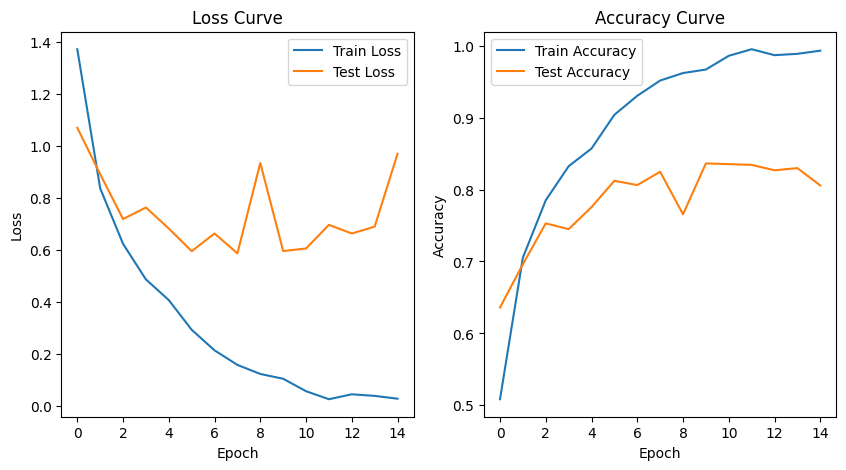

In [18]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

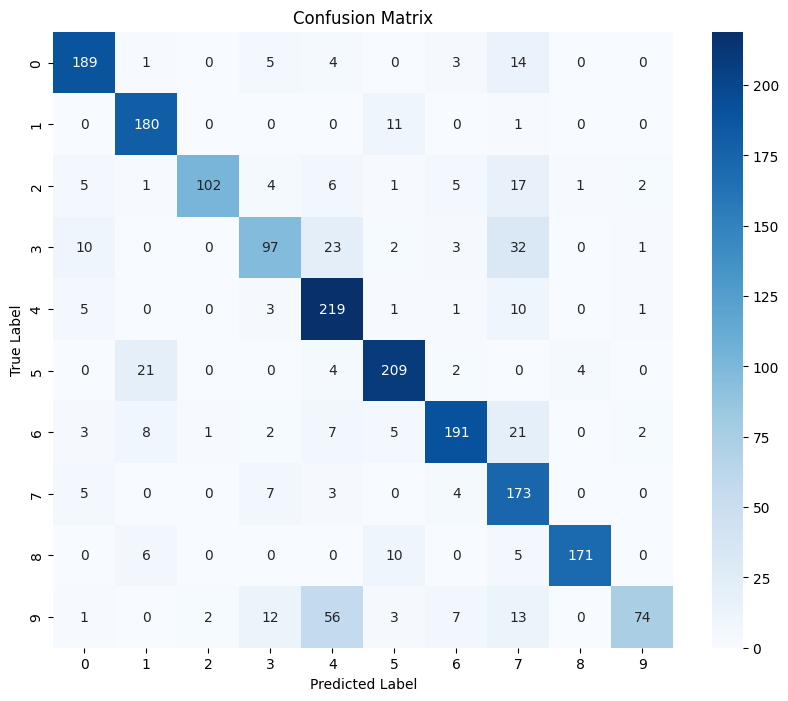

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to calculate and plot confusion matrix
def plot_confusion_matrix(loader, model, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
plot_confusion_matrix(test_loader, model, device)

# Avg F1-score criteria

In [ ]:

# Initialize logging
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
train_f1_scores, test_f1_scores = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_true_train, y_pred_train = [], []  # To store true labels and predictions for F1 score

    # Training phase
    for images, labels in train_loader:
        images = images.to(device).float()  # Move images to GPU
        labels = labels.to(device).long()   # Move labels to GPU

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Accuracy calculation for training data
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accumulate true labels and predictions for F1 score
        y_true_train.extend(labels.cpu().numpy())  # Move labels back to CPU
        y_pred_train.extend(predicted.cpu().numpy())  # Move predictions back to CPU

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Compute F1 score for training
    f1_macro_train = f1_score(y_true_train, y_pred_train, average='macro')
    f1_micro_train = f1_score(y_true_train, y_pred_train, average='micro')
    f1_train = (f1_macro_train + f1_micro_train) / 2

    # Append training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(f1_train)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_true_test, y_pred_test = [], []  # To store true labels and predictions for F1 score

    with torch.no_grad():  # No need to calculate gradients during validation
        for images, labels in test_loader:
            images = images.to(device).float()  # Move images to GPU
            labels = labels.to(device).long()   # Move labels to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Accuracy calculation for test data
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accumulate true labels and predictions for F1 score
            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_acc = correct / total

    # Compute F1 score for validation
    f1_macro_test = f1_score(y_true_test, y_pred_test, average='macro')
    f1_micro_test = f1_score(y_true_test, y_pred_test, average='micro')
    f1_test = (f1_macro_test + f1_micro_test) / 2

    # Append test metrics
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    test_f1_scores.append(f1_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Train F1: {f1_train:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {f1_test:.4f}')
